# Non-Boosting Methods

In this notebook will be some additional problems regarding non-boosting ensemble learning methods. This material corresponds to lectures:
- `Lectures/Supervised Learning/Ensemble Learning/1. What is Ensemble Learning`,
- `Lectures/Supervised Learning/Ensemble Learning/2. Random Forests`,
- `Lectures/Supervised Learning/Ensemble Learning/3. Bagging and Pasting` and
- `Lectures/Supervised Learning/Ensemble Learning/8. Voter Models`.

In [1]:
## For data handling
import pandas as pd
import numpy as np

## For plotting
import matplotlib.pyplot as plt
import seaborn as sns

## This sets the plot style
## to have a grid on a dark background
sns.set_style("whitegrid")

##### 1. 

If you have trained five different models on the exact same training data, and they all achieve $95\%$ precision, is there any chance that you can combine these models to get better results? If so, how? If not, why?

##### Sample Solution

If the errors for the five models are different enough from one another, a voter model could be used to improve on the performance of the model.

##### 2. Voter Model Regression

While we implemented a voter model for a classification problem, it can also be used for regression purposes. In this setting the voter model provides a predicted value by taking a weighted average (the default is to use uniform weights) of its constituent regressor model's predictions.

In `sklearn` this is done with `VotingRegressor` <a href="https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.VotingRegressor.html">https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.VotingRegressor.html</a>.

Load in the `baseball_run_diff.csv` data set from the `data` folder. Build a `VotingRegressor` model to predict `W` using `RD`. Let your constituent models be simple linear regression, $k$-nearest neighbors using $k=10$ and an extra trees regressor with `max_depth=4`. Plot the predictions on top of the training data for the voter model as well as each individual constituent model. In addition create a validation set and provide the performance of the voter model and each individual constituent model on the validation set.

##### Sample Solution

In [2]:
## load the data here
baseball = pd.read_csv("../../../data/baseball_run_diff.csv")

In [3]:
## make a train test split
from sklearn.model_selection import train_test_split

baseball_train, baseball_test = train_test_split(baseball.copy(), 
                                                    shuffle=True,
                                                    random_state=314,
                                                    test_size=.2)

## make a validation set
baseball_train_train, baseball_val = train_test_split(baseball_train.copy(), 
                                                        shuffle=True,
                                                        random_state=13241,
                                                        test_size=.2)

In [4]:
## import any model objects you need
from sklearn.ensemble import ExtraTreesRegressor, VotingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor

In [5]:
## make the model objects
slr = LinearRegression()
et = ExtraTreesRegressor(max_depth=4)
knn = KNeighborsRegressor(10)
vr = VotingRegressor([('slr', LinearRegression()),
                         ('et', ExtraTreesRegressor(max_depth=4)),
                         ('knn', KNeighborsRegressor(10))])

## fit the models
slr.fit(baseball_train_train['RD'].values.reshape(-1,1), baseball_train_train['W'])
et.fit(baseball_train_train['RD'].values.reshape(-1,1), baseball_train_train['W'])
knn.fit(baseball_train_train['RD'].values.reshape(-1,1), baseball_train_train['W'])
vr.fit(baseball_train_train['RD'].values.reshape(-1,1), baseball_train_train['W'])

## get predictions for plotting purposes
x = np.linspace(-340,340,600).reshape(-1,1)

slr_pred = slr.predict(x)
et_pred = et.predict(x)
knn_pred = knn.predict(x)
vr_pred = vr.predict(x)

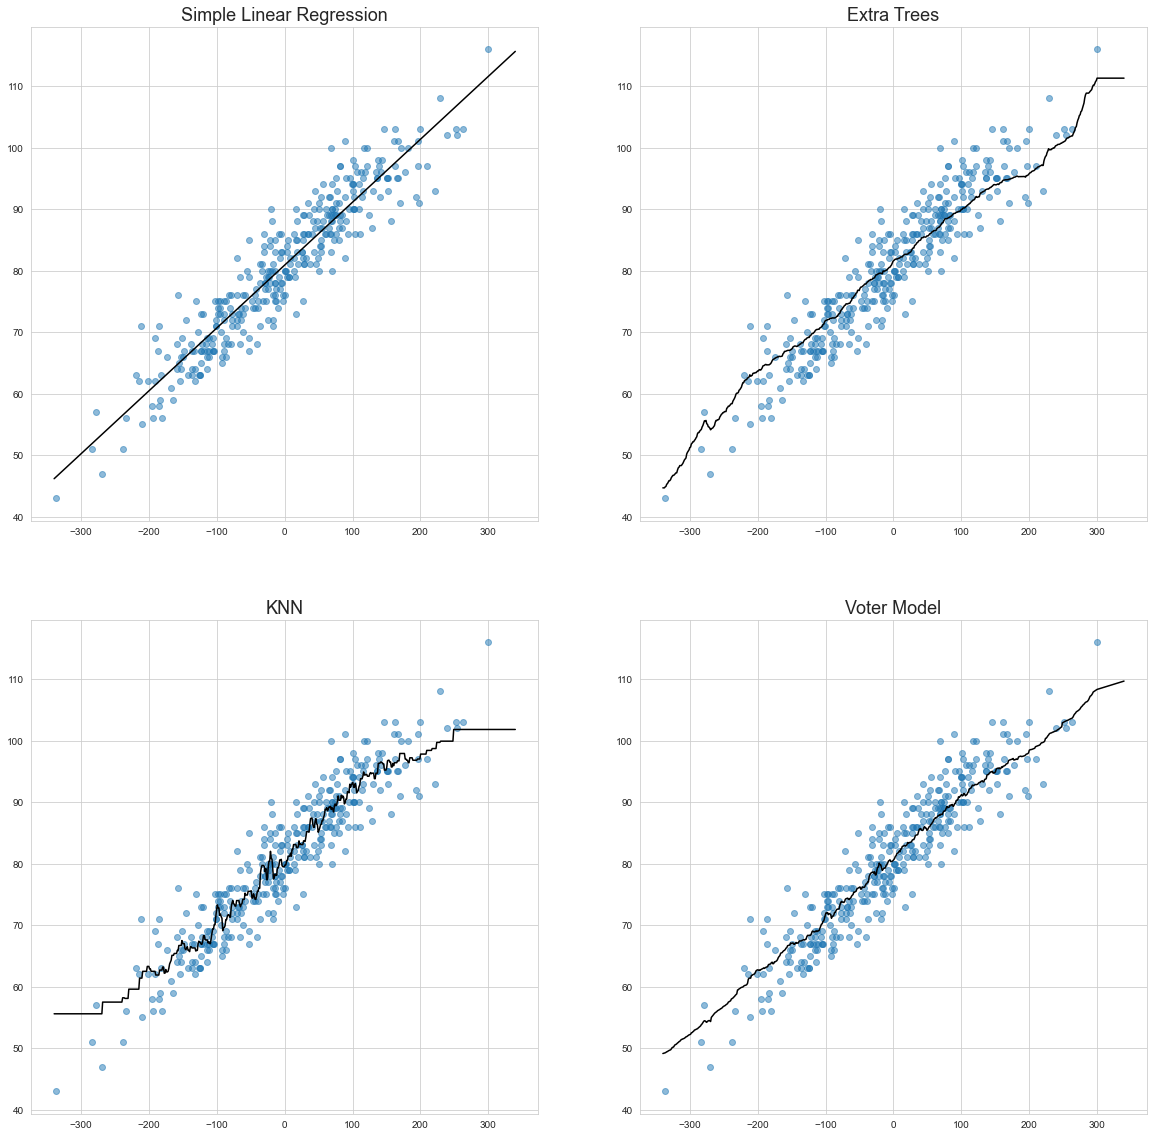

In [6]:
## plotted data and predictions
fig,ax = plt.subplots(2, 2, figsize=(20,20))

ax[0,0].scatter(baseball_train_train.RD, baseball_train_train.W, alpha=.5)
ax[0,0].plot(x, slr_pred, "k")
ax[0,0].set_title("Simple Linear Regression", fontsize=18)


ax[0,1].scatter(baseball_train_train.RD, baseball_train_train.W, alpha=.5)
ax[0,1].plot(x, et_pred, "k")
ax[0,1].set_title("Extra Trees", fontsize=18)


ax[1,0].scatter(baseball_train_train.RD, baseball_train_train.W, alpha=.5)
ax[1,0].plot(x, knn_pred, "k")
ax[1,0].set_title("KNN", fontsize=18)


ax[1,1].scatter(baseball_train_train.RD, baseball_train_train.W, alpha=.5)
ax[1,1].plot(x, vr_pred, "k")
ax[1,1].set_title("Voter Model", fontsize=18)

plt.show()


In [7]:
from sklearn.metrics import mean_squared_error

print("Simple linear regression validation set MSE is",
         mean_squared_error(baseball_val.W.values, 
                               slr.predict(baseball_val['RD'].values.reshape(-1,1))))
print("Extra trees validation set MSE is",
         mean_squared_error(baseball_val.W.values, 
                               et.predict(baseball_val['RD'].values.reshape(-1,1))))
print("KNN validation set MSE is",
         mean_squared_error(baseball_val.W.values, 
                               knn.predict(baseball_val['RD'].values.reshape(-1,1))))
print("Voter Model regression validation set MSE is",
         mean_squared_error(baseball_val.W.values, 
                               vr.predict(baseball_val['RD'].values.reshape(-1,1))))

Simple linear regression validation set MSE is 17.102110744594142
Extra trees validation set MSE is 16.9322406771756
KNN validation set MSE is 16.150114942528738
Voter Model regression validation set MSE is 15.9905124729046


##### 3. Bagging/Pasting Regression

Similarly to 2., we can use bagging/pasting models for regression as well. Here we use a regression model as our base estimator and then to make a prediction take an average of all `n_estimators` models' predictions. In `sklearn` this is performed with `BaggingRegressor`, <a href="https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingRegressor.html">https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingRegressor.html</a>, where just like `BaggingClassifier` whether you perform bagging or pasting is determined by `bootstrap`.

Build a bagging regression model on that baseball data using a $k$NN regressor with $k=5$ as the base estimator. Plot the training data, the $k$NN regression prediction and the bagging prediction on the same plot. Use `n_estimators=5`, `bootstrap=True` and `max_samples = int(.25*len(baseball_train))`.


<i>Would using a bagging regressor introduce more bias or variance to your model?</i>

##### Sample Solution

<b>Answer: Bias</b>

In [8]:
from sklearn.ensemble import BaggingRegressor

In [9]:
## make the model objects
bag = BaggingRegressor(KNeighborsRegressor(5),
                          bootstrap=True,
                          n_estimators=500,
                          max_samples = int(.25*len(baseball_train)))

knn = KNeighborsRegressor(5)

## fit the models
knn.fit(baseball_train['RD'].values.reshape(-1,1), baseball_train['W'])
bag.fit(baseball_train['RD'].values.reshape(-1,1), baseball_train['W'])

## get predictions for plotting purposes
x = np.linspace(-340,340,600).reshape(-1,1)

knr_pred = knn.predict(x)
bag_pred = bag.predict(x)

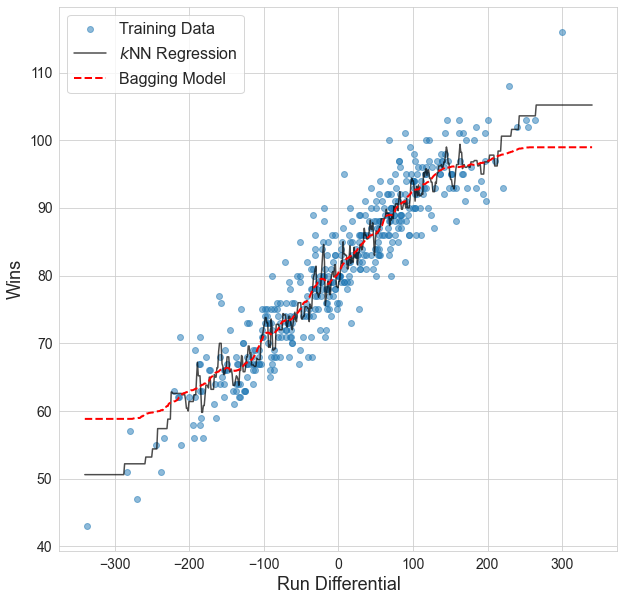

In [10]:
plt.figure(figsize=(10,10))

plt.scatter(baseball_train.RD, baseball_train.W, label="Training Data", alpha=.5)

plt.plot(x, knr_pred, 'k', label="$k$NN Regression", alpha=.7)
plt.plot(x, bag_pred, 'r--', label="Bagging Model", linewidth=2)

plt.xlabel("Run Differential", fontsize=18)
plt.ylabel("Wins", fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=16)

plt.show()

##### 4. Introducing MNIST

The MNIST dataset is a database of $60,000$ handwritten digits. It has been used to help create computer vision algorithms in detecting handwritten digits. It is also a common dataset used when teaching classification. 

We will first go through the data together, then you will build a voting classifier on the data.

In [11]:
## Load the data, this can take a while
## For speed, we'll use the sklearn version of the data
## which is smaller data set, and has a lower resolution
## than the original data set
from sklearn.datasets import load_digits

X,y = load_digits(return_X_y=True)

In [12]:
# Each observation contains the grayscale values for an 8 x 8 grid
X[0,:]

array([ 0.,  0.,  5., 13.,  9.,  1.,  0.,  0.,  0.,  0., 13., 15., 10.,
       15.,  5.,  0.,  0.,  3., 15.,  2.,  0., 11.,  8.,  0.,  0.,  4.,
       12.,  0.,  0.,  8.,  8.,  0.,  0.,  5.,  8.,  0.,  0.,  9.,  8.,
        0.,  0.,  4., 11.,  0.,  1., 12.,  7.,  0.,  0.,  2., 14.,  5.,
       10., 12.,  0.,  0.,  0.,  0.,  6., 13., 10.,  0.,  0.,  0.])

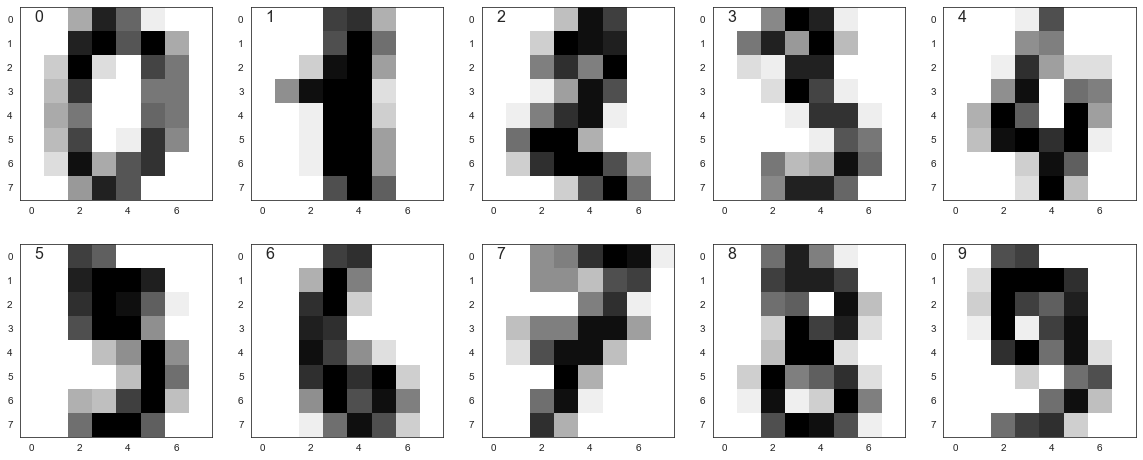

In [13]:
sns.set_style("white")

fig,ax = plt.subplots(2,5,figsize=(20,8))

for i in range(10):
    ax[i//5,i%5].imshow(X[i,:].reshape(8, 8), cmap='gray_r')
    ax[i//5,i%5].text(.1,.1,str(y[i]),fontsize=16)

plt.show()

In [14]:
## I'll scale X for you prior to the split, this ensures
## each value is in the range of 0 to 1
X = X/255

## Perform the split here
## set aside 20% for the test set
## stratify on y
X_train,X_test,y_train,y_test = train_test_split(X,y,
                                                    test_size = .2,
                                                    shuffle = True,
                                                    random_state=440,
                                                    stratify=y) 

Use cross-validation to find the number of neighbors for a KNN classifier that produces the highest mean cv accuracy.

In [15]:
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold

from sklearn.neighbors import KNeighborsClassifier

In [16]:
neighbors = range(1,20)

accs = np.zeros((5, len(neighbors)))

kfold = StratifiedKFold(5, random_state=1341, shuffle=True)

i = 0
for train_index, test_index in kfold.split(X_train, y_train):
    X_train_train = X_train[train_index,:]
    y_train_train = y_train[train_index]
    X_holdout = X_train[test_index,:]
    y_holdout = y_train[test_index]

    for j in neighbors:
        knn = KNeighborsClassifier(j)
        knn.fit(X_train_train, y_train_train)
        accs[i,j-1] = accuracy_score(y_holdout, knn.predict(X_holdout))
    i = i + 1

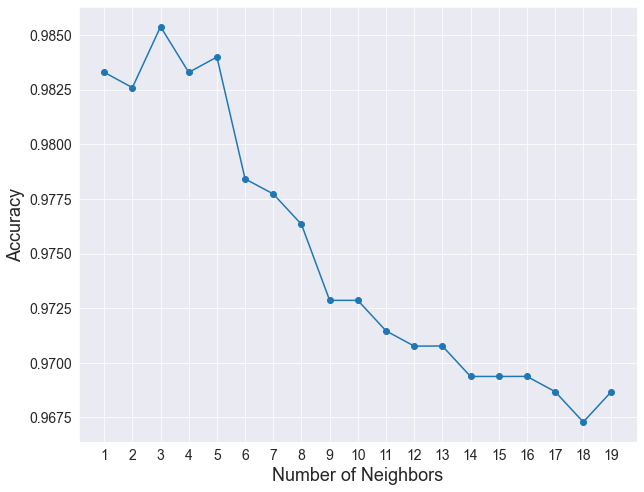

In [17]:
sns.set_style("darkgrid")
plt.figure(figsize=(10,8))

plt.plot(neighbors, np.mean(accs, axis=0), '-o')

plt.xlabel("Number of Neighbors", fontsize=18)
plt.ylabel("Accuracy", fontsize=18)

plt.xticks(neighbors,fontsize=14)
plt.yticks(fontsize=14)


plt.show()

Perform cross-validation to select the optimal value for `max_depth` for a `RandomForestClassifier`.

In [18]:
from sklearn.ensemble import RandomForestClassifier

In [19]:
depths = range(1,21)

accs = np.zeros((5, len(depths)))

kfold = StratifiedKFold(5, random_state=1341, shuffle=True)

i = 0
for train_index, test_index in kfold.split(X_train, y_train):
    X_train_train = X_train[train_index,:]
    y_train_train = y_train[train_index]
    X_holdout = X_train[test_index,:]
    y_holdout = y_train[test_index]

    for j in depths:
        rf = RandomForestClassifier(max_depth=j)
        rf.fit(X_train_train, y_train_train)
        accs[i,j-1] = accuracy_score(y_holdout, rf.predict(X_holdout))
    i = i + 1

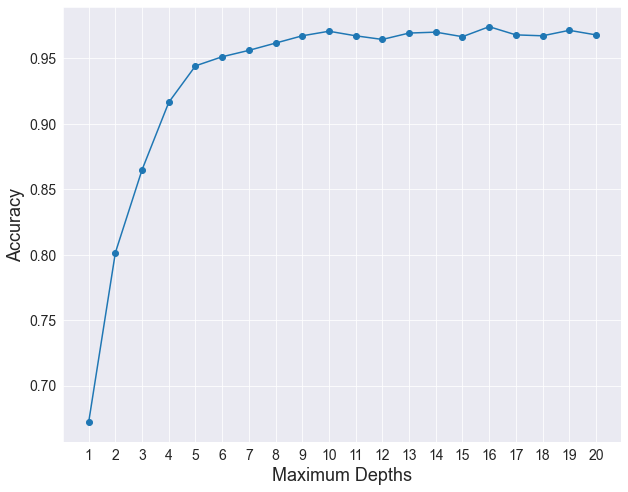

In [20]:
sns.set_style("darkgrid")
plt.figure(figsize=(10,8))

plt.plot(depths, np.mean(accs, axis=0), '-o')

plt.xlabel("Maximum Depths", fontsize=18)
plt.ylabel("Accuracy", fontsize=18)

plt.xticks(depths,fontsize=14)
plt.yticks(fontsize=14)


plt.show()

Now build a voter model with KNN using the number of neighbors you just found, a random forest model using the maximum depth you just found and a linear discriminant analysis model. Find the cross-validation accuracy for the voter model and each model individually.

In [21]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import VotingClassifier

In [22]:
lda_accs = np.zeros(5)
rf_accs = np.zeros(5)
knn_accs = np.zeros(5)
vm_accs = np.zeros(5)

lda = LinearDiscriminantAnalysis()
rf = RandomForestClassifier(max_depth=10)
knn = KNeighborsClassifier(3)
vm = VotingClassifier([('lda',LinearDiscriminantAnalysis()),
                          ('rf',RandomForestClassifier(max_depth=10)),
                          ('knn',KNeighborsClassifier(3))])

kfold = StratifiedKFold(5, random_state=1341, shuffle=True)

i = 0
for train_index, test_index in kfold.split(X_train, y_train):
    X_train_train = X_train[train_index,:]
    y_train_train = y_train[train_index]
    X_holdout = X_train[test_index,:]
    y_holdout = y_train[test_index]
    
    lda = LinearDiscriminantAnalysis()
    rf = RandomForestClassifier(max_depth=10)
    knn = KNeighborsClassifier(3)
    vm = VotingClassifier([('lda',LinearDiscriminantAnalysis()),
                              ('rf',RandomForestClassifier(max_depth=10)),
                              ('knn',KNeighborsClassifier(3))])
    
    
    lda.fit(X_train_train, y_train_train)
    rf.fit(X_train_train, y_train_train)
    knn.fit(X_train_train, y_train_train)
    vm.fit(X_train_train, y_train_train)
    
    
    lda_accs[i] = accuracy_score(y_holdout, lda.predict(X_holdout))
    rf_accs[i] = accuracy_score(y_holdout, rf.predict(X_holdout))
    knn_accs[i] = accuracy_score(y_holdout, knn.predict(X_holdout))
    vm_accs[i] = accuracy_score(y_holdout, vm.predict(X_holdout))
    
    i = i + 1

In [23]:
accuracy_score(y_train, lda.predict(X_train))

0.9624217118997912

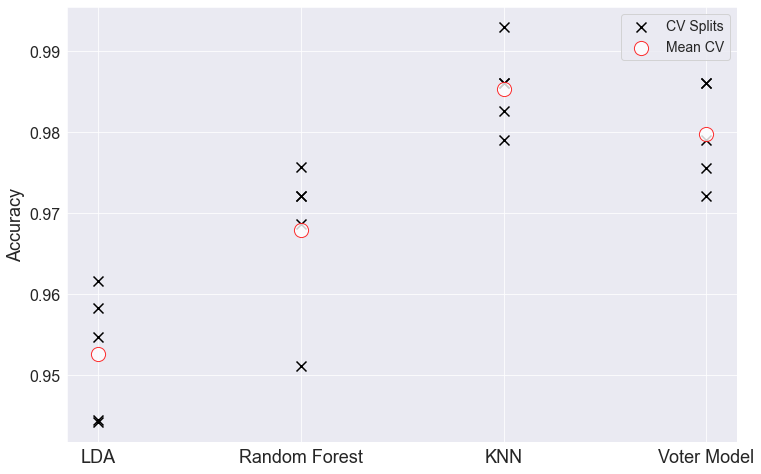

In [24]:
plt.figure(figsize=(12,8))

plt.scatter(np.zeros(5), lda_accs, c='k', marker='x', s=100, label="CV Splits")
plt.scatter(np.ones(5), rf_accs, c='k', marker='x', s=100 )
plt.scatter(2*np.ones(5), knn_accs, c='k', marker='x', s=100 )
plt.scatter(3*np.ones(5), vm_accs, c='k', marker='x', s=100)

plt.scatter([0], np.mean(lda_accs), c='white', edgecolor='r', alpha=.8, s=200, label="Mean CV")
plt.scatter([1], np.mean(rf_accs), c='white', edgecolor='r', alpha=.8, s=200)
plt.scatter([2], np.mean(knn_accs), c='white', edgecolor='r', alpha=.8, s=200)
plt.scatter([3], np.mean(vm_accs), c='white', edgecolor='r', alpha=.8, s=200)

plt.xticks(range(4), ['LDA', 'Random Forest', 'KNN', 'Voter Model'], fontsize=18)

plt.ylabel("Accuracy", fontsize=18)
plt.yticks(fontsize=16)
plt.legend(fontsize=14)


plt.show()

--------------------------

This notebook was written for the Erd&#337;s Institute C&#337;de Data Science Boot Camp by Matthew Osborne, Ph. D., 2023.

Any potential redistributors must seek and receive permission from Matthew Tyler Osborne, Ph.D. prior to redistribution. Redistribution of the material contained in this repository is conditional on acknowledgement of Matthew Tyler Osborne, Ph.D.'s original authorship and sponsorship of the Erdős Institute as subject to the license (see License.md)